<a href="https://colab.research.google.com/github/IanOliv/IanOliv/blob/main/%5BM%C3%B3dulo_2_1%5D_Feature_Engineering_Atividade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Módulo 2.1] Pré-processamento de dados com Pandas e Scikit-learn

## 1. Objetivos

Este notebook tem como objetivo aplicar técnicas de Feature Engineering (Engenharia de Atributos) vistas na aula no contexto de um problema real de aprendizado de máquina: prever se a renda anual de um indivíduo excede 50 mil dólares, com base em dados do censo dos Estados Unidos.

Mais especificamente, o foco será em:

- Compreender e explorar as variáveis do conjunto de dados;
- Tratar valores faltantes e inconsistências;
- Transformar variáveis categóricas (ex.: codificação one-hot, ordinal);
- Criar e selecionar atributos derivados que possam melhorar a performance do modelo;
- Normalizar e padronizar atributos numéricos;
- Preparar os dados para modelagem supervisionada.

O dataset utilizado é o Adult Census Income, disponível publicamente no Kaggle: https://www.kaggle.com/datasets/uciml/adult-census-income/data. É necessário possuir uma conta no Kaggle para realizar o download. Após baixar os arquivos, recomendamos organizá-los em uma pasta datasets no mesmo diretório deste notebook.

A etapa de engenharia de atributos é fundamental em qualquer pipeline de Machine Learning, pois influencia diretamente o desempenho do modelo. Através desta atividade, serão exploradas boas práticas e transformações úteis para preparar os dados da forma mais informativa possível.

## 2. Análise dos Dados

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [7]:
path = kagglehub.dataset_download("uciml/adult-census-income",path='adult.csv')

print(path)

/kaggle/input/adult-census-income/adult.csv


In [8]:
# Carregando o arquivo CSV
# O arquivo 'adult.csv' deve estar no mesmo diretório que este script
# ou você pode especificar o caminho completo para o arquivo
# O parâmetro na_values é usado para tratar valores ausentes
# Aqui, estamos tratando '#NAME?' como um valor ausente
df = pd.read_csv(path, na_values=['#NAME?'])
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [9]:
# Vamos ver a variável alvo 'income', que indica se a pessoa ganha mais de 50K por ano
print(df['income'].value_counts())

income
<=50K    24720
>50K      7841
Name: count, dtype: int64


A explicação das features:

* **`age`**: Idade do indivíduo. (Numérica)
* **`workclass`**: Tipo de empregador ou setor de trabalho. Exemplos: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. (Categórica)
* **`fnlwgt` (final weight)**: O peso final atribuído pelo censo. Este é um peso estatístico que indica quantas pessoas a linha de observação representa. Não é uma feature preditiva direta, mas é usada para garantir que as estatísticas do censo sejam representativas da população. (Numérica)
* **`education`**: Nível de escolaridade do indivíduo. Exemplos: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. (Categórica)
* **`education-num`**: Representação numérica do nível de escolaridade. Valores mais altos indicam maior nível de educação. (Numérica)
* **`marital-status`**: Estado civil do indivíduo. Exemplos: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. (Categórica)
* **`occupation`**: Ocupação principal do indivíduo. Exemplos: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. (Categórica)
* **`relationship`**: Relação familiar do indivíduo. Exemplos: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. (Categórica)
* **`race`**: Raça do indivíduo. Exemplos: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. (Categórica)
* **`sex`**: Sexo do indivíduo. Exemplos: Female, Male. (Categórica)
* **`capital-gain`**: Ganhos de capital do indivíduo. (Numérica)
* **`capital-loss`**: Perdas de capital do indivíduo. (Numérica)
* **`hours-per-week`**: Número de horas trabalhadas por semana. (Numérica)
* **`native-country`**: País de origem do indivíduo. (Categórica)
* **`income`**: Variável alvo, indicando se a renda do indivíduo é `>50K` (maior que $50.000) ou `<=50K` (menor ou igual a $50.000) por ano. (Categórica/Binária)

Diferente do dataset que usamos para predizer o preço de casas, aqui nossa tarefa é dizer se uma pessoa recebe mias ou menos que $50 mil. Isso significa que temos um outro tipo de problema: uma **classificação binária**, que significa que a saída do nosso modelo vai dizer *sim* ou *não* (na verdade, *0* ou *1*) se a pessoa recebe mais que $50K. Vamos então ajustar a coluna *income* para refletir corretamente essa saída:

In [10]:
df['income'] = [0 if x == '<=50K' else 1 for x in df['income']]

Crie alguns gráficos para visualizar e entende os dados! Tente entender como o nosso target se comporta, as correlações entre algumas variáveis, distribuições, dados faltantes, etc. Não existe um gráfico específico certo aqui, então seja criativo.

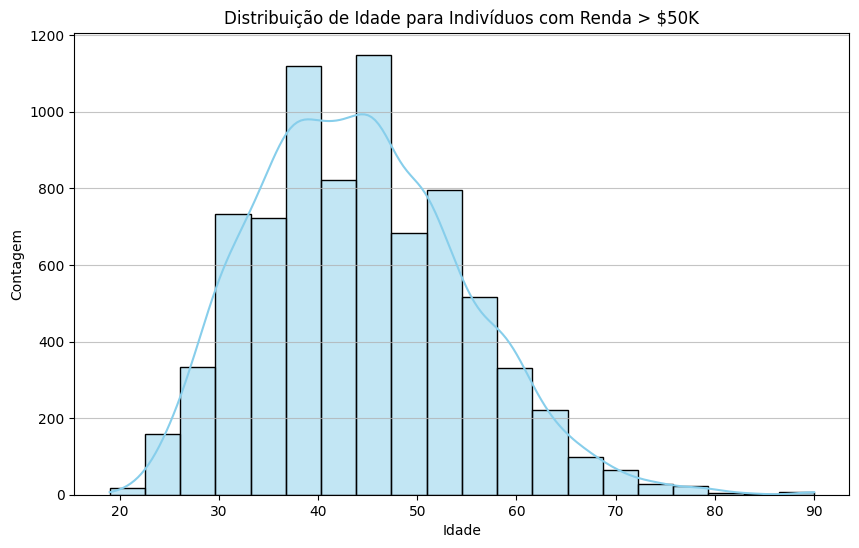

In [11]:
df_high_income = df[df['income'] == 1]

plt.figure(figsize=(10, 6))
sns.histplot(df_high_income['age'], bins=20, kde=True, color='skyblue')
plt.title('Distribuição de Idade para Indivíduos com Renda > $50K')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [18]:
num_df = df.select_dtypes(include=['int64','float64'])

corr = num_df.corr()['income'].sort_values(ascending=False)

print('Correlação com a coluna "income":')
print(corr.head(7))


Correlação com a coluna "income":
income            1.000000
education.num     0.335154
age               0.234037
hours.per.week    0.229689
capital.gain      0.223329
capital.loss      0.150526
fnlwgt           -0.009463
Name: income, dtype: float64


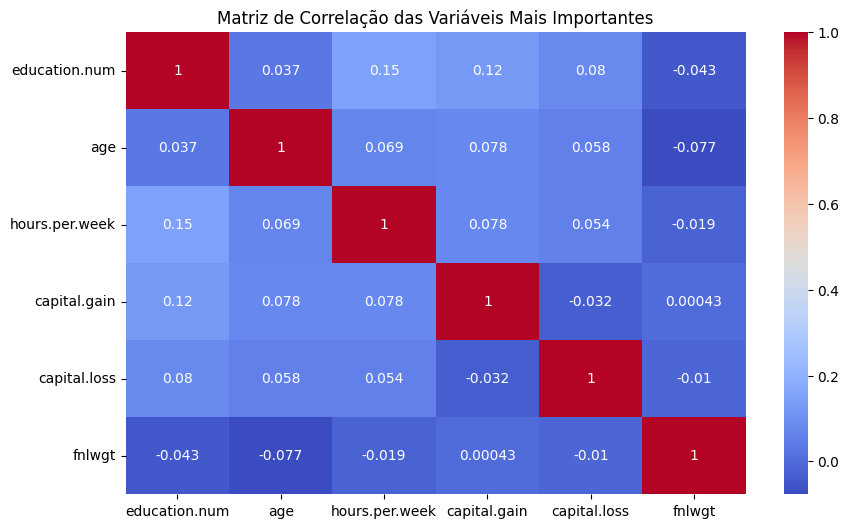

In [20]:
top_corr = corr.index[1:7]

plt.figure(figsize=(10, 6))
sns.heatmap(df[top_corr].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação das Variáveis Mais Importantes')
plt.show()







Text(0, 0.5, 'hours.per.week')

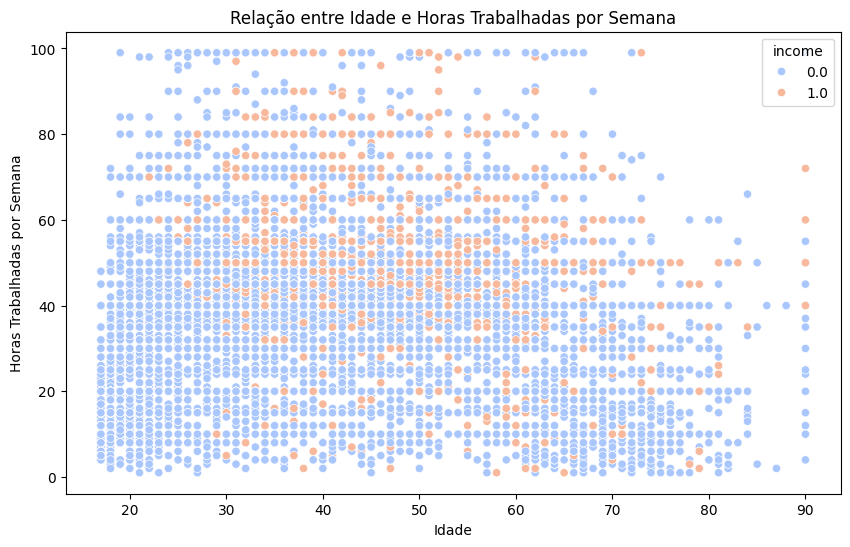

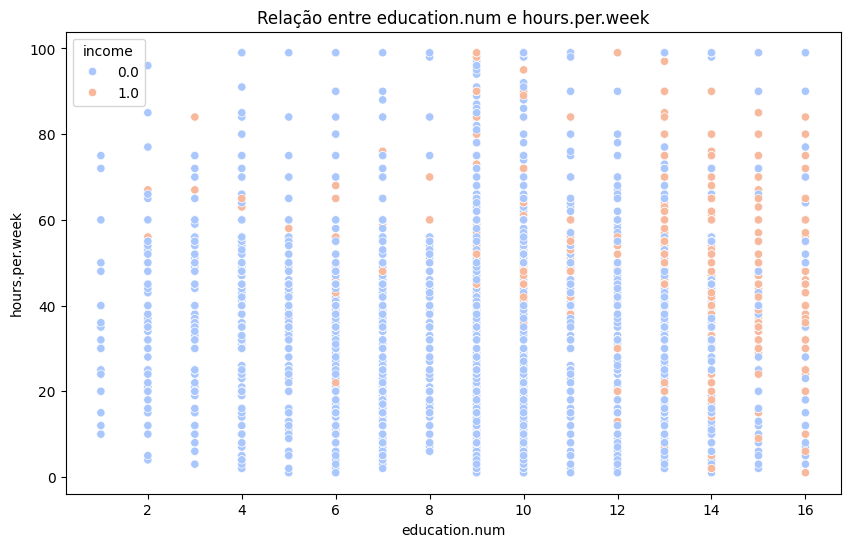

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='hours.per.week', hue='income', palette='coolwarm')
plt.title('Relação entre Idade e Horas Trabalhadas por Semana')
plt.xlabel('Idade')
plt.ylabel('Horas Trabalhadas por Semana')

# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df, x='age', y='income', hue='income', palette='coolwarm')
# plt.title('Relação entre Idade e Horas Trabalhadas por Semana')
# plt.xlabel('Idade')
# plt.ylabel('Horas Trabalhadas por Semana')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='education.num', y='hours.per.week', hue='income', palette='coolwarm')
plt.title('Relação entre education.num e hours.per.week')
plt.xlabel('education.num')
plt.ylabel('hours.per.week')




Text(0, 0.5, 'capital.loss')

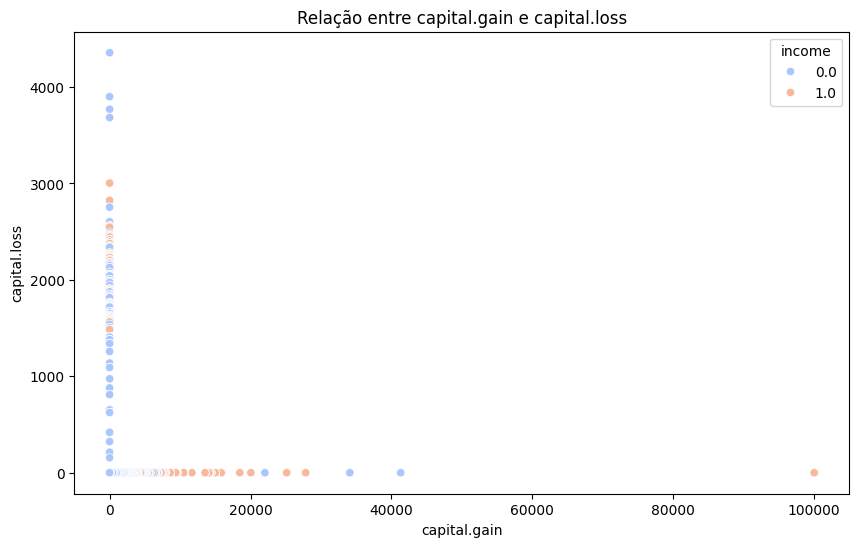

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='capital.gain', y='capital.loss', hue='income', palette='coolwarm')
plt.title('Relação entre capital.gain e capital.loss')
plt.xlabel('capital.gain')
plt.ylabel('capital.loss')

Text(0.5, 1.0, 'Relação entre education.num e hours.per.week')

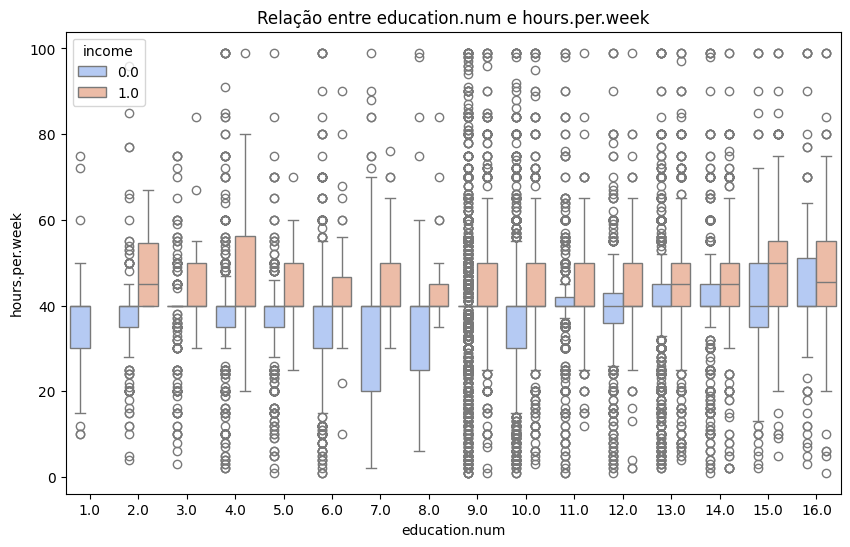

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='education.num', y='hours.per.week', hue='income', palette='coolwarm')
plt.title('Relação entre education.num e hours.per.week')
# plt.xlabel('education.num')
# plt.ylabel('hours.per.week')
# x='education.num', y='hours.per.week'


## 3. Limpeza e Tratativas

Verifique se o dataset precisa de limpeza e realize algumas tratativas (transformação de features, etc.). Lembre-se que os modelos de ML a priori não lidam com valores categóricos!

In [41]:
print("\nContagem de NaNs antes da limpeza:")
print(df.isnull().sum())


Contagem de NaNs antes da limpeza:
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


In [13]:
# Separando colunas numéricas e categóricas
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

In [14]:
imputer_numerical = SimpleImputer(strategy='mean')
imputer_categorical = SimpleImputer(strategy='most_frequent')

# Aplica a imputação
df[numerical_features] = imputer_numerical.fit_transform(df[numerical_features])
df[categorical_features] = imputer_categorical.fit_transform(df[categorical_features])

In [42]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90.0,?,77053.0,HS-grad,9.0,Widowed,?,Not-in-family,White,Female,0.0,4356.0,40.0,United-States,0.0
1,82.0,Private,132870.0,HS-grad,9.0,Widowed,Exec-managerial,Not-in-family,White,Female,0.0,4356.0,18.0,United-States,0.0
2,66.0,?,186061.0,Some-college,10.0,Widowed,?,Unmarried,Black,Female,0.0,4356.0,40.0,United-States,0.0
3,54.0,Private,140359.0,7th-8th,4.0,Divorced,Machine-op-inspct,Unmarried,White,Female,0.0,3900.0,40.0,United-States,0.0
4,41.0,Private,264663.0,Some-college,10.0,Separated,Prof-specialty,Own-child,White,Female,0.0,3900.0,40.0,United-States,0.0


## 4. Criação de Features

Use a criatividade para criar novas features. Se quiser (e vai ser bem legal), é enriquecer os dados com outro dataset, já que o nosso tem poucas features.

In [44]:
bins = [0, 18, 25, 35, 45, 55, 65, np.inf]
labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['AgeGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
categorical_features.append('AgeGroup')


In [49]:
df[['age', 'AgeGroup']].head()

,age,AgeGroup
0,90.0,65+
1,82.0,65+
2,66.0,65+
3,54.0,45-54
4,41.0,35-44


In [48]:
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 45, 65, 100], labels=['Young', 'Adult', 'Senior', 'Elder'])


<Axes: xlabel='age_group', ylabel='education.num'>

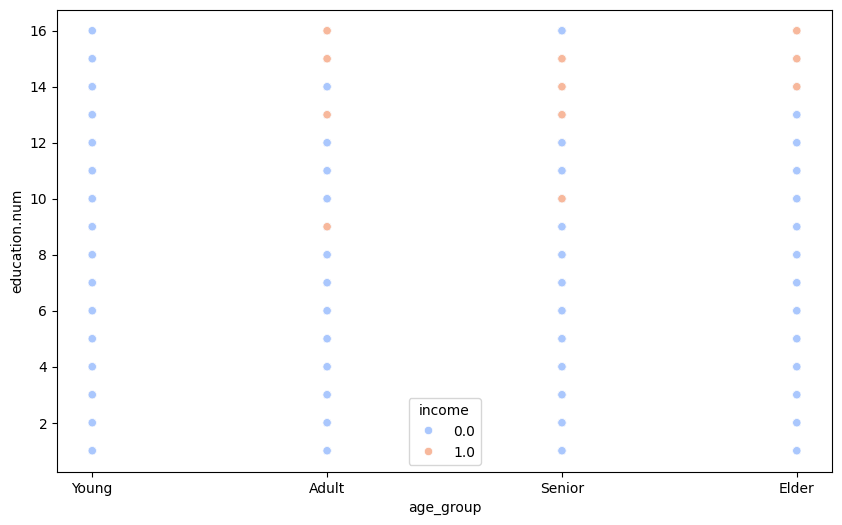

In [62]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age_group', y='education.num', hue='income', palette='coolwarm')

In [51]:
df[['age', 'AgeGroup','age_group']].head()

,age,AgeGroup,age_group
0,90.0,65+,Elder
1,82.0,65+,Elder
2,66.0,65+,Elder
3,54.0,45-54,Senior
4,41.0,35-44,Adult


In [53]:
df['is_male'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)


<Axes: xlabel='income', ylabel='is_male'>

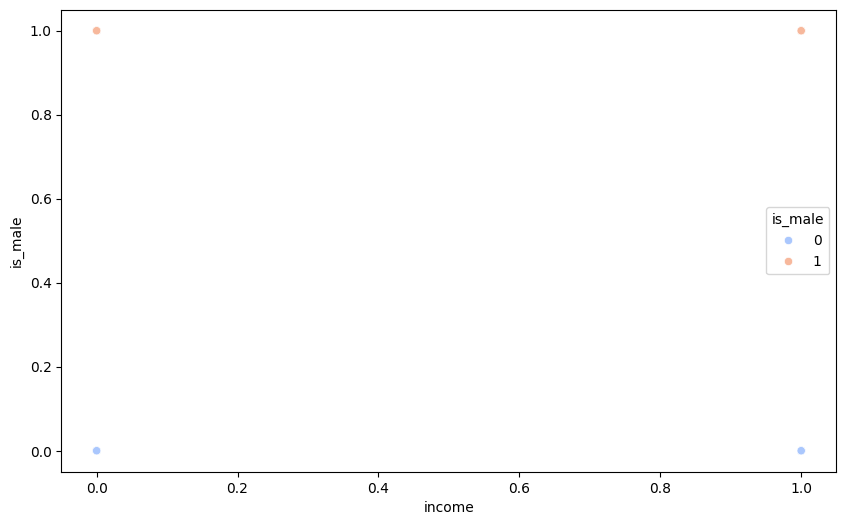

In [66]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='income', y='is_male', hue='is_male', palette='coolwarm')

In [54]:
df[['is_male']].head()

,is_male
0,0
1,0
2,0
3,0
4,0


In [56]:
df['edu_hours'] = df['education.num'] * df['hours.per.week']

In [57]:
df['edu_hours'].head()

,edu_hours
0,360.0
1,162.0
2,400.0
3,160.0
4,400.0


## 5. Escalar/Padronizar os valores

Aqui estamos usando funções prontas (que valem a pena o estudo), mas recomendamos usar funções próprias

In [80]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

X = df.drop(labels=['income','is_male','edu_hours'], axis=1)
y = df['income']

# Replace '?' with np.nan in the dataframe
X = X.replace('?', np.nan)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
# Identify categorical features excluding 'AgeGroup' and 'age_group'
categorical_features = X.select_dtypes(include='object').columns.tolist()
# Remove 'AgeGroup' and 'age_group' from categorical features to be processed
categorical_features = [f for f in categorical_features if f not in ['AgeGroup', 'age_group']]


# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop other columns (AgeGroup and age_group)
)

In [74]:
numerical_features

['age',
 'fnlwgt',
 'education.num',
 'capital.gain',
 'capital.loss',
 'hours.per.week']

## 6. Rodando um modelo

Teste outros modelos, ou até mesmo uma rede neural! Não precisa também estar dentro do Pipeline

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])


model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

# Avalia o modelo
print("\n--- Avaliação do Modelo ---")
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


--- Avaliação do Modelo ---
Acurácia no conjunto de teste: 0.8512

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      4945
         1.0       0.73      0.61      0.67      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.77      0.78      6513
weighted avg       0.85      0.85      0.85      6513

